In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (5).json


{'kaggle (5).json': b'{"username":"saramattarr","key":"83fde2c1782d6935fdb8e8f2eb44d90f"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d  andrewmvd/hard-hat-detection -p data --unzip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection
License(s): CC0-1.0
100% 1.22G/1.22G [00:04<00:00, 258MB/s]
100% 1.22G/1.22G [00:04<00:00, 291MB/s]


In [5]:
!mkdir -p dataset/images/train dataset/images/val dataset/images/test
!mkdir -p dataset/labels/train dataset/labels/val dataset/labels/test


In [6]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path
import shutil
import random

RAW_IMG_DIR = "data/images"
RAW_ANN_DIR = "data/annotations"
OUT_DIR = "dataset"

CLASSES = ["helmet", "no_helmet"]
SPLIT_RATIO = {"train": 0.7, "val": 0.2, "test": 0.1}

def convert_box(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x_center = (box[0] + box[1]) / 2.0
    y_center = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x_center * dw, y_center * dh, w * dw, h * dh)


images = list(Path(RAW_IMG_DIR).glob("*.png"))
random.shuffle(images)

n_total = len(images)
n_train = int(n_total * SPLIT_RATIO["train"])
n_val = int(n_total * SPLIT_RATIO["val"])

splits = {
    "train": images[:n_train],
    "val": images[n_train:n_train + n_val],
    "test": images[n_train + n_val:]
}

for split, files in splits.items():
    os.makedirs(f"{OUT_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{OUT_DIR}/labels/{split}", exist_ok=True)

    for img_path in files:
        xml_path = Path(RAW_ANN_DIR) / (img_path.stem + ".xml")
        if not xml_path.exists():
            continue

        tree = ET.parse(xml_path)
        root = tree.getroot()

        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        yolo_lines = []

        for obj in root.iter("object"):
            cls_name = obj.find("name").text
            if cls_name == "helmet":
                cls_id = 0
            elif cls_name == "head":
                cls_id = 1
            else:
                continue

            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            xmax = float(bndbox.find("xmax").text)
            ymin = float(bndbox.find("ymin").text)
            ymax = float(bndbox.find("ymax").text)

            bb = convert_box((w, h), (xmin, xmax, ymin, ymax))
            yolo_lines.append(f"{cls_id} {bb[0]:.6f} {bb[1]:.6f} {bb[2]:.6f} {bb[3]:.6f}")

        if yolo_lines:
            label_path = Path(f"{OUT_DIR}/labels/{split}/{img_path.stem}.txt")
            with open(label_path, "w") as f:
                f.write("\n".join(yolo_lines))

            shutil.copy(img_path, f"{OUT_DIR}/images/{split}/{img_path.name}")

print("Conversion completed!")


Conversion completed!


In [7]:
!ls dataset/images/train | head
!ls dataset/labels/train | head


hard_hat_workers0.png
hard_hat_workers1000.png
hard_hat_workers1001.png
hard_hat_workers1002.png
hard_hat_workers1003.png
hard_hat_workers1004.png
hard_hat_workers1006.png
hard_hat_workers1007.png
hard_hat_workers1008.png
hard_hat_workers1009.png
hard_hat_workers0.txt
hard_hat_workers1000.txt
hard_hat_workers1001.txt
hard_hat_workers1002.txt
hard_hat_workers1003.txt
hard_hat_workers1004.txt
hard_hat_workers1006.txt
hard_hat_workers1007.txt
hard_hat_workers1008.txt
hard_hat_workers1009.txt


In [8]:
%%writefile data.yaml
path: dataset
train: images/train
val: images/val
test: images/test

nc: 2
names: ['helmet', 'no_helmet']


Overwriting data.yaml


In [9]:
!cat data.yaml


path: dataset
train: images/train
val: images/val
test: images/test

nc: 2
names: ['helmet', 'no_helmet']


In [10]:
!pip install ultralytics --upgrade


In [11]:
!yolo detect train data=data.yaml model=yolov8s.pt epochs=30 imgsz=640


Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretra

In [12]:
import pandas as pd



In [13]:
metrics = pd.read_csv("runs/detect/train/results.csv")
metrics.head()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2,lr/pg3,lr/pg4,lr/pg5,lr/pg6,lr/pg7
0,1,158.058,1.63776,1.89020,1.34885,0.85752,0.79358,0.86985,0.51087,1.38194,0.81411,1.21854,0.001661,0.000554,0.001661,0.000554,0.001661,0.000554,0.001661,0.000554
1,2,298.666,1.35542,0.83611,1.14670,0.91063,0.87190,0.92950,0.58209,1.28753,0.62844,1.12989,0.003218,0.001073,0.003218,0.001073,0.003218,0.001073,0.003218,0.001073
2,3,433.368,1.30215,0.72370,1.10216,0.91850,0.87422,0.93266,0.58294,1.28779,0.62553,1.12155,0.004665,0.001555,0.004665,0.001555,0.004665,0.001555,0.004665,0.001555
3,4,566.369,1.27634,0.69241,1.08279,0.92093,0.88833,0.94880,0.62116,1.23447,0.57499,1.10901,0.004506,0.001502,0.004506,0.001502,0.004506,0.001502,0.004506,0.001502
4,5,699.307,1.26237,0.66811,1.07759,0.92830,0.89912,0.95708,0.62688,1.23010,0.56409,1.08692,0.004341,0.001447,0.004341,0.001447,0.004341,0.001447,0.004341,0.001447


In [14]:
import matplotlib.pyplot as plt




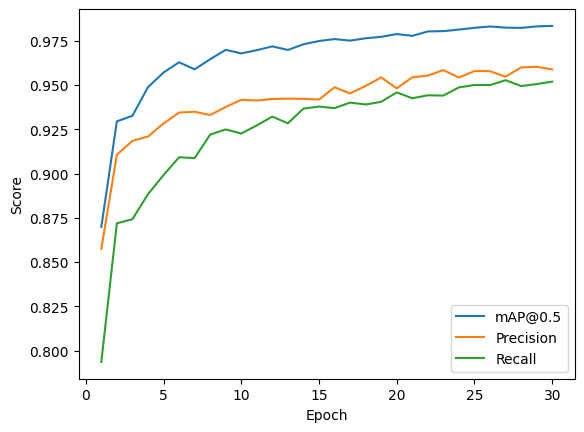

In [15]:
plt.plot(metrics['epoch'], metrics['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(metrics['epoch'], metrics['metrics/precision(B)'], label='Precision')
plt.plot(metrics['epoch'], metrics['metrics/recall(B)'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()

In [16]:
!yolo val model=runs/detect/train/weights/best.pt data=data.yaml


Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2455.6±292.8 MB/s, size: 268.5 KB)
val: Scanning /content/dataset/labels/val.cache... 2429 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2429/2429 261.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 152/152 3.8it/s 40.2s
                   all       2429      11974      0.959      0.954      0.983      0.722
                helmet       2226       9197      0.968      0.959      0.987      0.734
             no_helmet        438       2777       0.95      0.948       0.98       0.71
Speed: 1.5ms preprocess, 9.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


In [17]:
!yolo predict model=runs/detect/train/weights/best.pt source=dataset/images/val save=True


Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs

image 1/2429 /content/dataset/images/val/hard_hat_workers1.png: 640x640 9 helmets, 16.3ms
image 2/2429 /content/dataset/images/val/hard_hat_workers10.png: 640x640 3 helmets, 16.2ms
image 3/2429 /content/dataset/images/val/hard_hat_workers1005.png: 640x640 6 helmets, 16.2ms
image 4/2429 /content/dataset/images/val/hard_hat_workers1008.png: 640x640 3 helmets, 16.2ms
image 5/2429 /content/dataset/images/val/hard_hat_workers101.png: 640x640 7 no_helmets, 16.2ms
image 6/2429 /content/dataset/images/val/hard_hat_workers1011.png: 640x640 2 helmets, 16.2ms
image 7/2429 /content/dataset/images/val/hard_hat_workers1012.png: 640x640 5 helmets, 14.3ms
image 8/2429 /content/dataset/images/val/hard_hat_workers1013.png: 640x640 4 helmets, 6 no_helmets, 14.4ms
image 9/2429 /content/dataset/images/val/hard_hat_workers1017.png: 640x640 2 helm


0: 640x640 9 helmets, 16.3ms
Speed: 4.9ms preprocess, 16.3ms inference, 17.5ms postprocess per image at shape (1, 3, 640, 640)


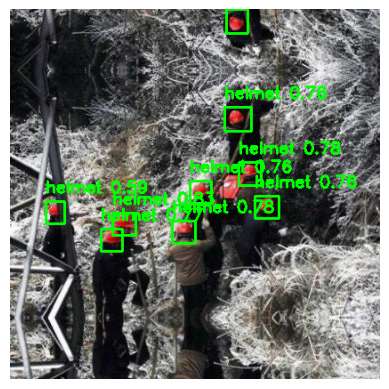

In [18]:
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt

model = YOLO("runs/detect/train/weights/best.pt")

img_path = "dataset/images/val/hard_hat_workers1.png"
img = cv2.imread(img_path)
results = model(img)

frame = img.copy()

for r in results:
    for box in r.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        label = f"{model.names[cls]} {conf:.2f}"
        color = (0, 255, 0) if cls == 0 else (0, 0, 255)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.axis('off')
plt.show()

In [19]:
!pip install gradio --upgrade


In [20]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")


In [ ]:


import gradio as gr

import numpy as np

def detect_hardhat(img):
    results = model(img)
    frame = img.copy()

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            label = f"{model.names[cls]} {conf:.2f}"
            color = (0, 255, 0) if cls == 0 else (0, 0, 255)  # green=helmet, red=no helmet
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return frame

iface = gr.Interface(
    fn=detect_hardhat,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Image(type="numpy"),
    title="Hard Hat Detection",
    description="Upload an image to detect helmets and people without helmets."
)

iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://18902c695dbb03567f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
